Import Libraries

In [ ]:
import csv
import os
import shutil
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict
import tensorflow as tf
import matplotlib.pyplot as plt

Nessecary File

In [ ]:
DATA_FIX_PATH = '../dataset/ASII.csv'

with open(DATA_FIX_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

timestamp,close

First data point looks like this:

2001-04-16,98

Second data point looks like this:

2001-04-17,96



Visualize the Stock Price

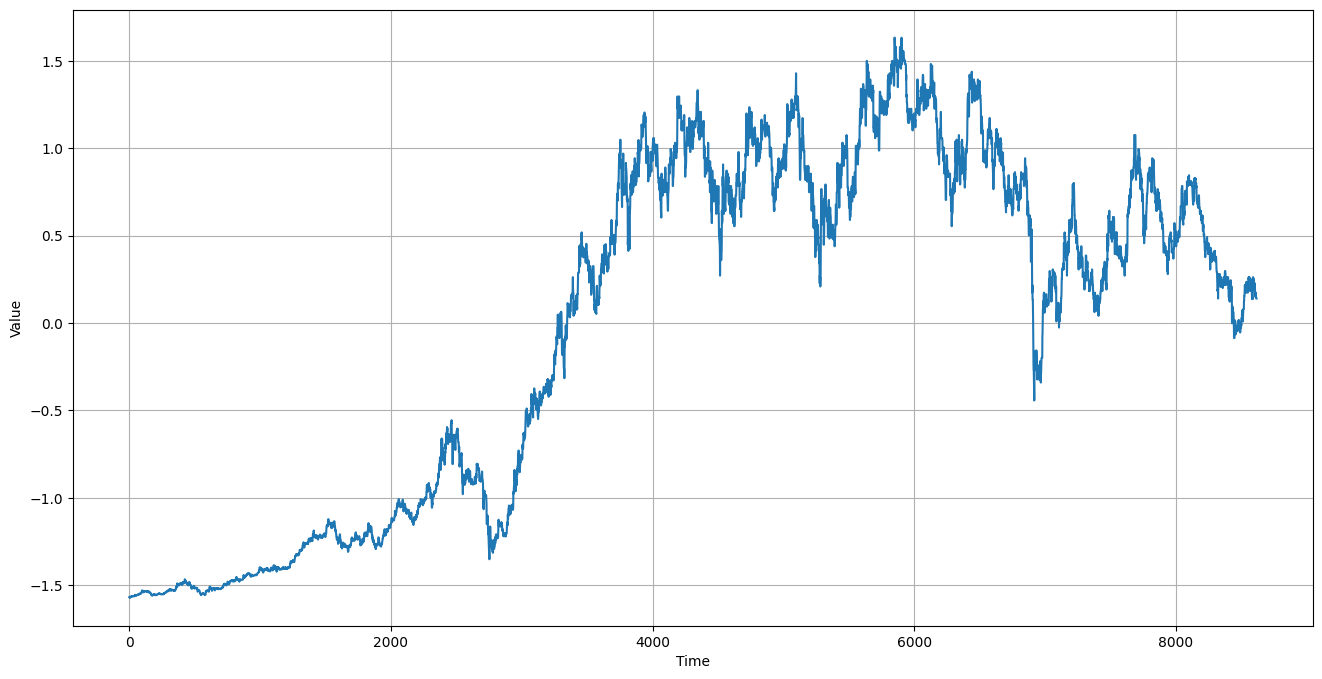

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def parse_data_from_file(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=1)
    closedStockPrice = data.astype(float)
    
    # Normalisasi yang lebih robust
    mean = np.mean(closedStockPrice)
    std = np.std(closedStockPrice)
    closedStockPrice = (closedStockPrice - mean) / std
    
    times = np.arange(len(data))
    
    return times, closedStockPrice, mean, std

TIME, SERIES, mean, std = parse_data_from_file(DATA_FIX_PATH)

plt.figure(figsize=(16, 8))
plot_series(TIME, SERIES)

Defining Global Variables

In [ ]:
SPLIT_TIME = 7000
WINDOW_SIZE = 224
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

Processing the Data

In [ ]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [ ]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [ ]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

Defining the Model Architecture

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        
        # First Conv1D layer dengan lebih banyak filter
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, 
                               strides=1, padding="causal", 
                               activation="relu"),
        tf.keras.layers.BatchNormalization(),  # Menambah stabilitas
        
        # LSTM layers dengan ukuran yang lebih besar
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  
        
        tf.keras.layers.LSTM(64),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(32, activation="relu", 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        loss=tf.keras.losses.Huber(delta=1.0),  # Huber loss untuk stabilitas
        optimizer=optimizer,
        metrics=["mae"]
    )
    
    return model

In [ ]:
model = create_model()

In [ ]:
example_batch = train_dataset.take(1)

try:
	predictions = model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

In [ ]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

In [ ]:
model.summary()

In [ ]:
# Callbacks untuk training yang lebih baik
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [ ]:
# Create dataset and train
train_dataset = windowed_dataset(series_train, WINDOW_SIZE)
validation_dataset = windowed_dataset(series_valid, WINDOW_SIZE)

In [ ]:
# Train model
history = model.fit(
    train_dataset,
    epochs=50,  # Lebih banyak epochs dengan early stopping
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Visualize the training loss

In [ ]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

In [ ]:
# Plot training metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()